# Kalman Gains

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import pandas as pd
from scipy.optimize import minimize

## Load the cleaned data

In [16]:
data = pd.read_csv('SPY_full_features.csv', index_col='Date')

In [17]:
data.head(10)

,SPY,SPY_ret_5,SPY_DD-log_5,SPY_sortino_5,SPY_ret_10,SPY_DD-log_10,SPY_sortino_10,SPY_ret_15,SPY_DD-log_15,SPY_sortino_15,...,SPY_sortino_105,SPY_ret_110,SPY_DD-log_110,SPY_sortino_110,SPY_ret_115,SPY_DD-log_115,SPY_sortino_115,SPY_ret_120,SPY_DD-log_120,SPY_sortino_120
Date,,,,,,,,,,,,,,,,,,,,,
1994-01-05,0.004027,0.004027,0.000000,0.000000,0.004027,0.000000,0.000000,0.004027,0.000000,0.000000,...,0.000000,0.004027,0.000000,0.000000,0.004027,0.000000,0.000000,0.004027,0.000000,0.000000
1994-01-06,0.002007,0.002947,0.000000,0.000000,0.002982,0.000000,0.000000,0.002994,0.000000,0.000000,...,0.000000,0.003014,0.000000,0.000000,0.003014,0.000000,0.000000,0.003014,0.000000,0.000000
1994-01-07,0.000000,0.001826,0.000000,0.000000,0.001918,0.000000,0.000000,0.001949,0.000000,0.000000,...,0.000000,0.002003,0.000000,0.000000,0.002003,0.000000,0.000000,0.002004,0.000000,0.000000
1994-01-10,0.005998,0.003095,0.000000,0.000000,0.003047,0.000000,0.000000,0.003033,0.000000,0.000000,...,0.000000,0.003011,0.000000,0.000000,0.003011,0.000000,0.000000,0.003011,0.000000,0.000000
1994-01-11,0.011890,0.005372,0.000000,0.000000,0.005068,0.000000,0.000000,0.004971,0.000000,0.000000,...,0.000000,0.004809,0.000000,0.000000,0.004808,0.000000,0.000000,0.004807,0.000000,0.000000
1994-01-12,-0.001972,0.003688,-6.965292,3.906780,0.003683,-7.041502,4.209815,0.003677,-7.068441,4.317411,...,4.510884,0.003661,-7.116800,4.512397,0.003661,-7.117140,4.513779,0.003661,-7.117451,4.515046
1994-01-13,-0.003295,0.002233,-6.363818,1.296096,0.002467,-6.445060,1.553393,0.002537,-6.474137,1.644663,...,1.808173,0.002649,-6.526744,1.809448,0.002649,-6.527116,1.810612,0.002650,-6.527456,1.811679
1994-01-14,-0.002644,0.001291,-6.247603,0.667100,0.001663,-6.322230,0.926119,0.001780,-6.349588,1.018834,...,1.185572,0.001972,-6.399823,1.186874,0.001974,-6.400181,1.188063,0.001975,-6.400510,1.189154
1994-01-17,0.003963,0.001776,-6.347806,1.014599,0.001995,-6.400142,1.200895,0.002070,-6.420786,1.272020,...,1.404788,0.002199,-6.460304,1.405847,0.002200,-6.460593,1.406815,0.002201,-6.460857,1.407702


## Kalman Filter Specification

In [22]:
dim_z = data.shape[1]  # number of features in the dataset
print(f"dim_z = {dim_z}")
kf = KalmanFilter(dim_x=1, dim_z=dim_z)

obs_1d = data['SPY'].values
obs_1d.shape

dim_z = 73


(7855,)

### Learning the SS parameters

In [ ]:
# Find the parameters for the KF by finding the MLE

def likelihood(params, obs):
    """Calculate the negative log-likelihood of the data given the parameters."""
    F, H, Q, R, P = params

    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.F = np.array([[F]])
    kf.H = np.array([[H]])
    kf.Q = np.array([[Q]])
    kf.R = np.array([[R]])  
    kf.x = np.array([[0]])
    kf.P = np.array([[P]]) 

    ll = 0.

    # KF loop
    for z in obs:
        kf.predict()
        kf.update(z)
        ll += kf.log_likelihood

    return -ll  # return negative log-likelihood for minimization

# Initial guess for parameters: F, H, Q, R, P
initial_params = [1.0, 1.0, 1e-5, 1e-5, 1.0]

# Minimize the negative log-likelihood
result = minimize(likelihood, initial_params, args=(obs_1d,), method='L-BFGS-B',
                  bounds=((0.1, 2.0), (0.1, 2.0), (1e-10, 1e-2), (1e-10, 1e-2), (0.1, 10.0)))

print("Optimized parameters:", result.x)

Optimized parameters: [9.99442785e-01 1.00061712e+00 1.00000000e-10 1.40492144e-04
 9.99999977e-01]


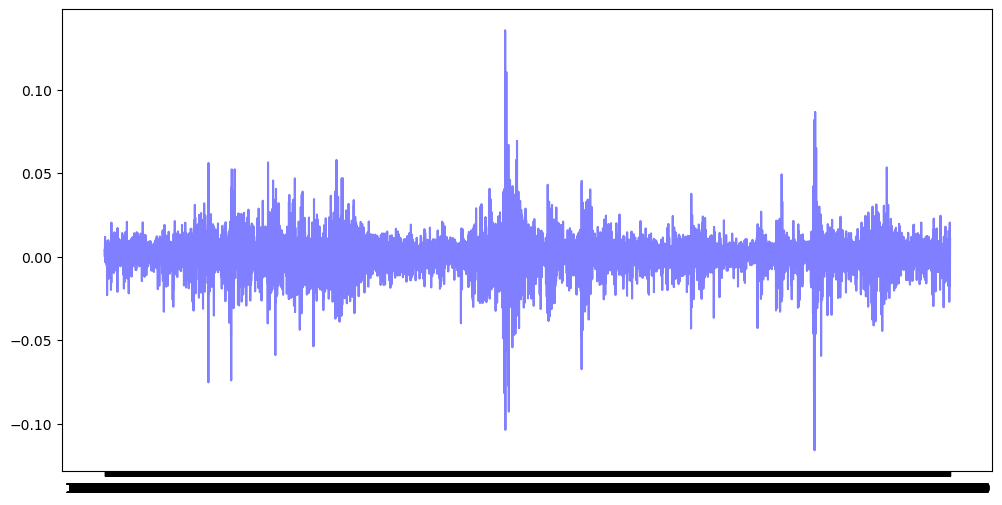

In [28]:
F, H, Q, R, P = result.x
kf = KalmanFilter(dim_x=1, dim_z=1)
kf.F = np.array([[F]])
kf.H = np.array([[H]])
kf.Q = np.array([[Q]])
kf.R = np.array([[R]])

# use this kf to predict hidden states for all obs in obs
kf.x = np.array([[0]])
kf.P = np.array([[P]])

predictions = np.zeros((len(obs_1d), 1))
for i, z in enumerate(obs_1d):
    kf.predict()
    kf.update(z)
    predictions[i] = kf.x[0]

# plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, obs_1d, label='Observed SPY', color='blue', alpha=0.5)
plt.show()

Optimized parameters: [0.2        1.         0.01       0.24844686 3.7155133 ]


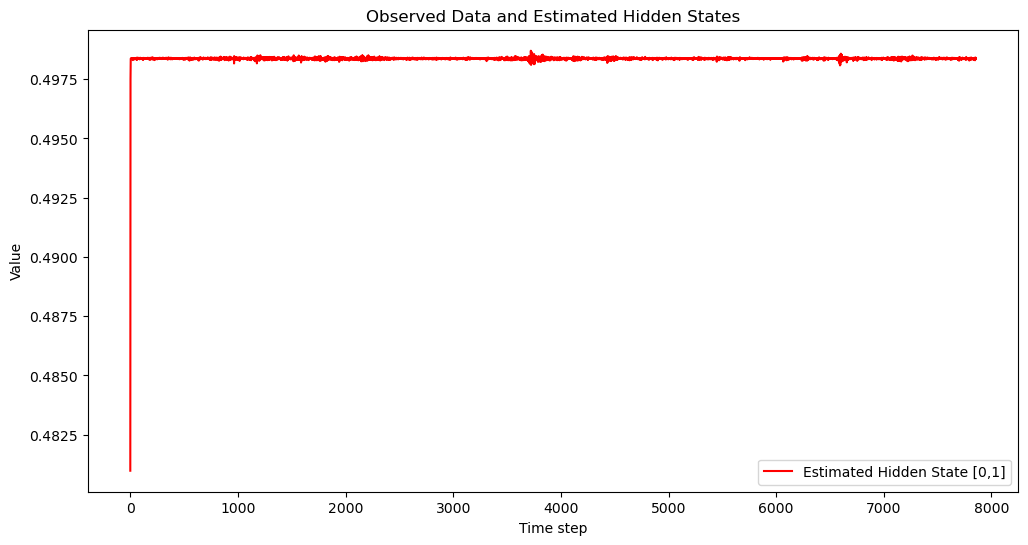

7855


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the sigmoid function and its derivative
def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def dsigmoid(y):
    s = sigmoid(y)
    return s * (1 - s)

# Extended Kalman Filter functions
def ekf_predict(y, P, F, Q):
    y_pred = F * y  # Linear state transition
    P_pred = F * P * F + Q
    return y_pred, P_pred

def ekf_update(y_pred, P_pred, z, H, R):
    # Measurement function: h(y) = sigmoid(y)
    z_pred = H * sigmoid(y_pred)
    # Jacobian of measurement function: H_jac = H * dsigmoid(y_pred)
    H_jac = H * dsigmoid(y_pred)
    # Innovation covariance
    S = H_jac * P_pred * H_jac + R
    # Kalman gain
    K = P_pred * H_jac / S
    # Updated state
    y_upd = y_pred + K * (z - z_pred)
    # Updated covariance
    P_upd = (1 - K * H_jac) * P_pred
    return y_upd, P_upd, z_pred

def likelihood(params, obs):
    """Calculate the negative log-likelihood of the data given the parameters.
       The state is reparameterized: actual state = sigmoid(y).
    """
    F, H, Q, R, P = params
    n = len(obs)

    # Initialize latent state (unconstrained) and covariance
    y = 0.0
    P_curr = P

    ll = 0.0

    for z in obs:
        # Prediction step
        y_pred, P_pred = ekf_predict(y, P_curr, F, Q)
        # Update step
        y, P_curr, z_pred = ekf_update(y_pred, P_pred, z, H, R)
        # Compute innovation (measurement residual)
        innov = z - z_pred
        # Innovation variance (from EKF)
        S = H * dsigmoid(y_pred) * P_pred * (H * dsigmoid(y_pred)) + R
        # Accumulate log-likelihood (assuming Gaussian noise)
        ll += -0.5 * (np.log(2 * np.pi * S) + (innov**2) / S)
        
    return -ll  # negative log-likelihood for minimization

# Initial guess for parameters: F, H, Q, R, P
initial_params = [0.15, 1.5, 1e-5, 0.01, 1.0]

result = minimize(likelihood, initial_params, args=(obs_1d,), method='L-BFGS-B',
                  bounds=((0.1, 0.2), (1.0, 2.0), (1e-10, 1e-2), (1e-3, 1.0), (0.1, 10.0)))
print("Optimized parameters:", result.x)

# Use the optimized parameters for filtering
F_opt, H_opt, Q_opt, R_opt, P_opt = result.x

# Initialize latent state (unconstrained) and covariance
y = 0.0
P_curr = P_opt
predictions = np.zeros((len(obs_1d), 1))
estimates = np.zeros((len(obs_1d), 1))

for i, z in enumerate(obs_1d):
    y_pred, P_pred = ekf_predict(y, P_curr, F_opt, Q_opt)
    y, P_curr, _ = ekf_update(y_pred, P_pred, z, H_opt, R_opt)
    # The estimate for the hidden state in [0,1] is given by the sigmoid of the latent state
    estimates[i] = sigmoid(y)

# Plot the observed data and the estimated hidden state
plt.figure(figsize=(12, 6))
# plt.plot(obs_1d, label='Observed Data', color='blue', alpha=0.5)
plt.plot(estimates, label='Estimated Hidden State [0,1]', color='red')
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Value")
plt.title("Observed Data and Estimated Hidden States")
plt.show()

print(len(obs_1d))

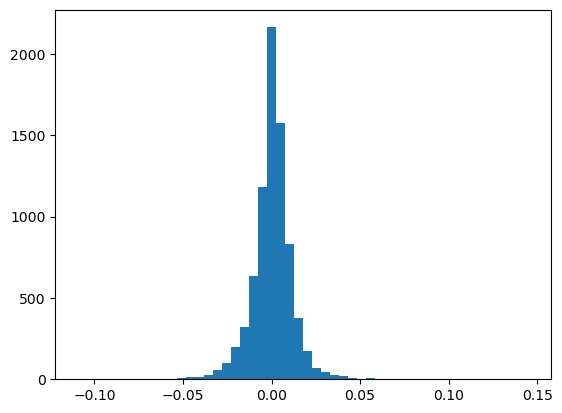

0.0004598408628021755

In [39]:
plt.hist(np.exp(obs_1d) - 1, bins=50)
plt.show()

np.mean(np.exp(obs_1d) - 1)

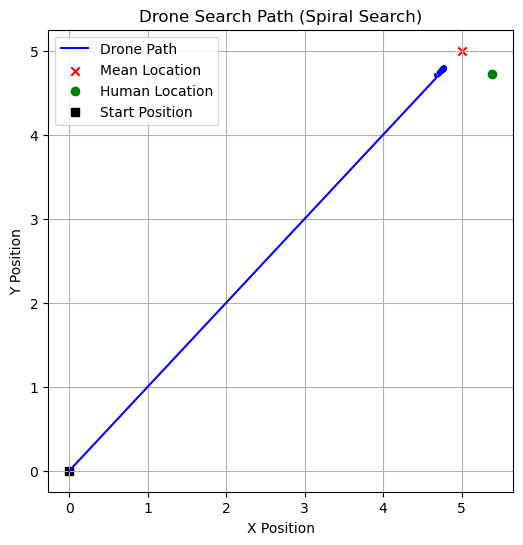

In [76]:
import numpy as np
import matplotlib.pyplot as plt


# Define parameters
mean_location = np.array([5, 5])  # (x*, y*) the center of the Gaussian
covariance = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix
human_location = np.random.multivariate_normal(mean_location, covariance)  # Sample human location

# Drone parameters
drone_position = np.array([0.0, 0.0])  # Ensure float type
speed = 0.2  # Constant speed
dt = 0.1  # Time step
t_max = 100  # Max time

# Reset trajectory tracking
trajectory = [drone_position.copy()]
search_radius = 0.5  # Consider "found" if within this distance

def spiral_search(drone_position, center, step_size, max_radius):
    """Performs an outward spiral search from the center."""
    angle = 0
    radius = step_size
    trajectory = [drone_position.copy()]
    
    while radius < max_radius:
        # Compute new position in spiral pattern
        angle += np.pi / 4  # Increment angle
        new_position = center + radius * np.array([np.cos(angle), np.sin(angle)])
        
        # Move toward new position
        direction = (new_position - drone_position) / np.linalg.norm(new_position - drone_position)
        drone_position += speed * direction * dt
        trajectory.append(drone_position.copy())

        # Increase search radius after a full rotation
        if angle >= 2 * np.pi:
            angle = 0
            radius += step_size

        # Stop if human is found
        if np.linalg.norm(drone_position - human_location) < search_radius:
            break

    return np.array(trajectory)

# Reset drone position
drone_position = np.array([0.0, 0.0])
trajectory = [drone_position.copy()]

# Phase 1: Move toward mean location
while np.linalg.norm(drone_position - mean_location) > search_radius:
    direction = (mean_location - drone_position) / np.linalg.norm(mean_location - drone_position)
    drone_position += speed * direction * dt
    trajectory.append(drone_position.copy())

# Phase 2: Spiral Search
spiral_trajectory = spiral_search(drone_position, mean_location, step_size=0.5, max_radius=5)
trajectory.extend(spiral_trajectory)

# Convert trajectory to array for plotting
trajectory = np.array(trajectory)

# Plot results
plt.figure(figsize=(6, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], label="Drone Path", color="blue")
plt.scatter(*mean_location, color="red", marker="x", label="Mean Location")
plt.scatter(*human_location, color="green", marker="o", label="Human Location")
plt.scatter(0, 0, color="black", marker="s", label="Start Position")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Drone Search Path (Spiral Search)")
plt.grid(True)
plt.show()



MovieWriter imagemagick unavailable; using Pillow instead.


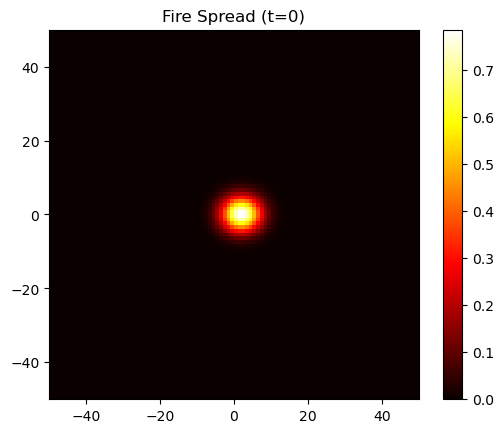

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.animation as animation

# Simulation parameters
Nx, Ny = 100, 100  # Grid size
dx, dy = 1.0, 1.0  # Grid spacing
dt = 1.0  # Time step
T = 20  # Number of time steps

# Wind velocity (u, v)
u, v = 2.0, 0.5  # Wind in x and y direction

# Initial fire shape (Gaussian blob in center)
x = np.linspace(-Nx//2, Nx//2, Nx)
y = np.linspace(-Ny//2, Ny//2, Ny)
X, Y = np.meshgrid(x, y)
fire = np.exp(-(X**2 + Y**2) / 20.0)  # Initial fire distribution

# Storage for frames
frames = []

# Time evolution
for t in range(T):
    # Shift the fire in the wind direction
    fire = np.roll(fire, shift=int(u), axis=1)  # Shift in x
    fire = np.roll(fire, shift=int(v), axis=0)  # Shift in y
    
    # Apply anisotropic diffusion (spread more in wind direction)
    fire = gaussian_filter(fire, sigma=[1, 2])  # More blur in x-direction
    
    # Store frame
    frames.append(fire.copy())

# Create animation
fig, ax = plt.subplots()
cbar = None
c = ax.imshow(frames[0], cmap='hot', origin='lower', extent=[-Nx//2, Nx//2, -Ny//2, Ny//2])
cbar = plt.colorbar(c, ax=ax)
ax.set_title("Fire Spread")

def update(frame):
    c.set_data(frames[frame])
    ax.set_title(f"Fire Spread (t={frame})")
    return c,

ani = animation.FuncAnimation(fig, update, frames=T, interval=100, blit=False)
ani.save('fire_spread.gif', writer='imagemagick', fps=10)